# ICONOMI Linear Regression Forecast

This notebook performs a linear regression forecast on the ICONOMI quarterly report data.

Please note that a linear regression on this kind of data does **not make sense at all** for forecasting future values, because the evolution of a company is inherentely non-linear. I primarily created this notebook to get to know ``sklearn`` and ``sklearn_pandas``.

Of course, every notebook starts with a couple of imports that we need later on:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import sklearn.linear_model
import sklearn
from sklearn_pandas import DataFrameMapper, cross_val_score
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 18, 'figure.facecolor': '1', 'figure.figsize': (10, 4)})

Next, let's load the ICONOMI dataset:

In [2]:
def parse_currency(s):
    return int(re.sub('[\$\.]', '', s))

df = pd.read_csv('ICONOMI/iconomi-overview.csv',
           engine='python', header=1, skipfooter=1, usecols=list(range(8)),
           converters={
               'Revenue': parse_currency,
               'Expenditures': parse_currency,
               'Net Burn Rate': parse_currency,
               'Book Value': parse_currency
           })
df

,Quarter,Revenue,Expenditures,Net Burn Rate,Book Value,Employees,DAA Managers,Users
0,2017 Q1,50936,562542,511606,21605453,20,0,0
1,2017 Q2,196996,646912,449916,148840329,30,0,4000
2,2017 Q3,57177,742314,685137,119787279,34,1,28268
3,2017 Q4,1015999,949356,-66643,327001779,36,18,43992
4,2018 Q1,114632,945348,830716,150921961,47,26,57975
5,2018 Q2,404410,1544306,1139896,148840329,49,34,60637
6,2018 Q3,65828,1327567,1261739,96200000,44,37,61627


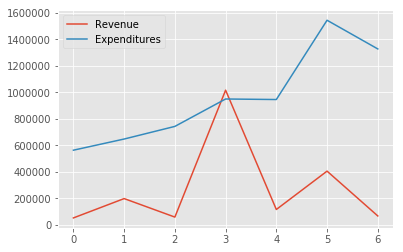

In [3]:
df[["Revenue", "Expenditures"]].plot();

Ok, so far, so good. Let's see what we can do with a linear regression.

## Create a linear regression and predict future values

A linear regression works by fitting model parameters to given data. To fit the data, we need to scale (or normalize) it first. In the following lines, the a ``DataFrameMapper`` is created with a ``StandardScaler`` for every column.

In [4]:
cols = df.columns[1:]
std_scaler = sklearn.preprocessing.StandardScaler()
mapper = DataFrameMapper([(cols, std_scaler)])

We can now use a ``LinearRegression`` to fit our data:

In [5]:
lm = sklearn.linear_model.LinearRegression()
lm.fit(np.array([df.index]).T, mapper.fit_transform(df.copy()));

/home/hannes/projects/iconomi-analysis/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/hannes/projects/iconomi-analysis/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Finally, we can predict the values for the coming quarters:

In [6]:
predict_quarters = list(range(6,14))
prediction = lm.predict(np.array([predict_quarters]).T)
predict_df = pd.DataFrame(std_scaler.inverse_transform(prediction))
predict_df = predict_df.rename({i: col for i, col in enumerate(cols)}, axis='columns')

def num_to_quarter(q, pos=None):
    "convert an index integer to a quarter string, in the form '2018 Q3'"
    return '{0} Q{1}'.format(int(2017 + q // 4), int(q % 4 + 1))

predict_df["Quarter"] = list(map(num_to_quarter, predict_quarters))
predict_df.index = np.array(predict_quarters)

## Visualizing the forecast

<Figure size 432x288 with 0 Axes>

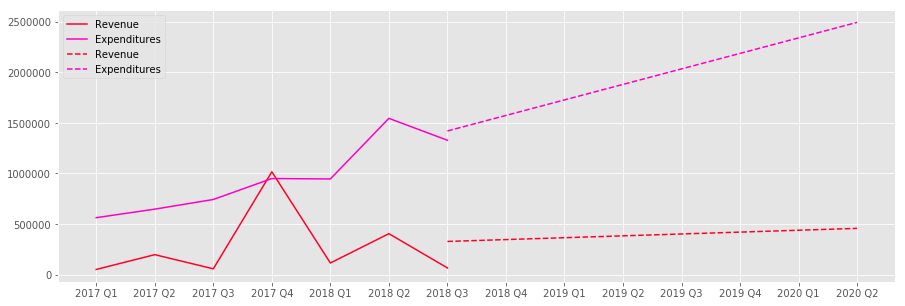

In [7]:
from matplotlib.ticker import FuncFormatter
ax = plt.figure()
fig, ax = plt.subplots(1, 1, figsize=(15,5))
df[["Revenue", "Expenditures"]].plot(ax=ax, colormap='gist_rainbow')
predict_df[["Revenue", "Expenditures"]].plot(ax=ax, colormap='gist_rainbow', style='--')
ax.get_xaxis().set_major_formatter(FuncFormatter(num_to_quarter))
ax.get_xaxis().set_ticks(range(predict_df.index.max() + 1));

<Figure size 432x288 with 0 Axes>

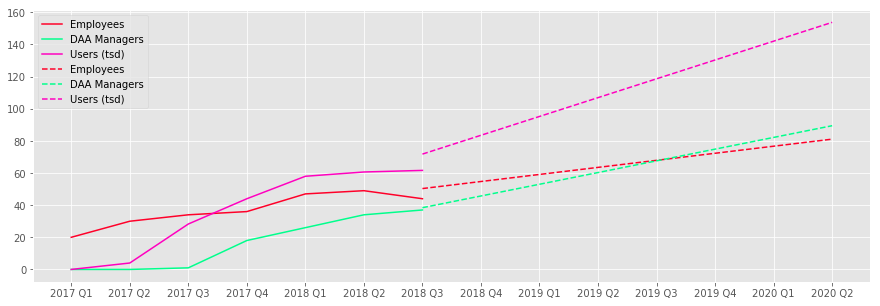

In [8]:
ax = plt.figure()
fig, ax = plt.subplots(1, 1, figsize=(15,5))
df["Users (tsd)"] = df["Users"] / 1000
predict_df["Users (tsd)"] = predict_df["Users"] / 1000
df[["Employees", "DAA Managers", "Users (tsd)"]].plot(ax=ax, colormap='gist_rainbow')
predict_df[["Employees", "DAA Managers", "Users (tsd)"]].plot(ax=ax, colormap='gist_rainbow', style='--')
ax.get_xaxis().set_major_formatter(FuncFormatter(num_to_quarter))
ax.get_xaxis().set_ticks(range(predict_df.index.max() + 1));